# MS1 Glycopeptide Traces

This notebook extracts the MS1 signal belonging to identified glycopeptides and plots them. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pickle
import ntpath 
import re 
import sys 
sys.path.append(r'../.')
from commons.data_processing import * 
from commons.my_mzml import *
from commons.byonic import ByFile

import warnings
warnings.filterwarnings('ignore')

## Important

You must provide the paths to the .mzXML files on your local machine for this to work.

In [2]:
# get byonic files
files = get_files('.', exts=['.xlsx'])

# get xml files
xmls = get_files(r"C:\Users\graha\Desktop\LocalData\NT1", exts=['.mzXML'])

In [3]:
# create pandas dataframe from byonic output of all runs 
all_runs = pd.DataFrame()
for file in files[:]:
    source, _ = ntpath.splitext(ntpath.basename(file))
    bf = ByFile(file)
    bf.fill_no_glycans()
    bf.remove_reverse(modify=True)
    bf.determine_glycosites()
    bf.filter_hits(score=100, modify=True)
    bf.frame = bf.reduce_frame(gp_only=True)
    bf.frame['source'] = [source]*len(bf.frame)
    bf.frame.sort_values('z', inplace=True)
    total = bf.total_gp()
    unique = bf.unique_gp()
    if all_runs.empty:
        all_runs = unique
    else:
        all_runs = pd.concat([all_runs, unique])

In [4]:
all_runs.head()

,clean_peptide,glycan,z,observed_mz,calc._mass_mh,glycosite,score,delta_mod,log_prob,peptide,protein_name,source
626,TDNATLLR,HexNAc(2)Hex(8),2,1324.5500,2648.0813,2524,145.15,15.46,2.25,K.[+42.011]TDN[+1702.581]ATLLR.L,>sp|Q8IZQ1|WDFY3_HUMAN WD repeat and FYVE doma...,BP_30C
70,VFGSQNLTTVK,HexNAc(2)Hex(8),2,1448.6292,2896.2338,516,279.52,96.66,6.74,R.VFGSQN[+1702.581]LTTVK.L,>sp|Q9Y4L1|HYOU1_HUMAN Hypoxia up-regulated pr...,BP_30C
619,TDNATLLR,HexNAc(2)Hex(9),2,1405.5788,2810.1341,2524,135.09,44.72,3.33,K.[+42.011]TDN[+1864.634]ATLLR.L,>sp|Q8IZQ1|WDFY3_HUMAN WD repeat and FYVE doma...,BP_30C
62,VFGSQNLTTVK,HexNAc(2)Hex(6),2,1286.5745,2572.1282,516,252.84,57.99,6.31,R.VFGSQN[+1378.476]LTTVK.L,>sp|Q9Y4L1|HYOU1_HUMAN Hypoxia up-regulated pr...,BP_30C
60,VFGSQNLTTVK,HexNAc(2)Hex(7),2,1367.6025,2734.1810,516,251.22,42.76,6.12,R.VFGSQN[+1540.529]LTTVK.L,>sp|Q9Y4L1|HYOU1_HUMAN Hypoxia up-regulated pr...,BP_30C


In [4]:
counts = all_runs.peptide.value_counts()
bpc = all_runs[all_runs.peptide.isin(counts[counts > 8].keys())]

pickle_filename = 'T10_EICs_bpc.p'

if os.path.exists(pickle_filename):
    d = pickle.load(open(pickle_filename, 'rb'))
else:
    d = {}
    for r in bpc.peptide.unique():
        sub = bpc[bpc.peptide==r]
        s = {}
        s['sequence'] = sub.clean_peptide.unique()
        s['glycan'] = sub.glycan.unique()
        s['masses'] = sub.observed_mz.values
        s['charges'] = sub.z.values
        s['sources'] = sub.source.values
        s['arrays'] = []
        d[r] = s

    for peptide in d:
        print(peptide)
        for i, source in enumerate(d[peptide]['sources']):
            file = [f for f in xmls if re.search(source, f)][0]
            m = mzXML(file)
            mass = d[peptide]['masses'][i]
            xs, ys = m.ms1_extract(mass, tolerance=10)
            d[peptide]['arrays'].append((xs, ys))

    pickle.dump(d, open(pickle_filename, 'wb'))

KeyboardInterrupt: 

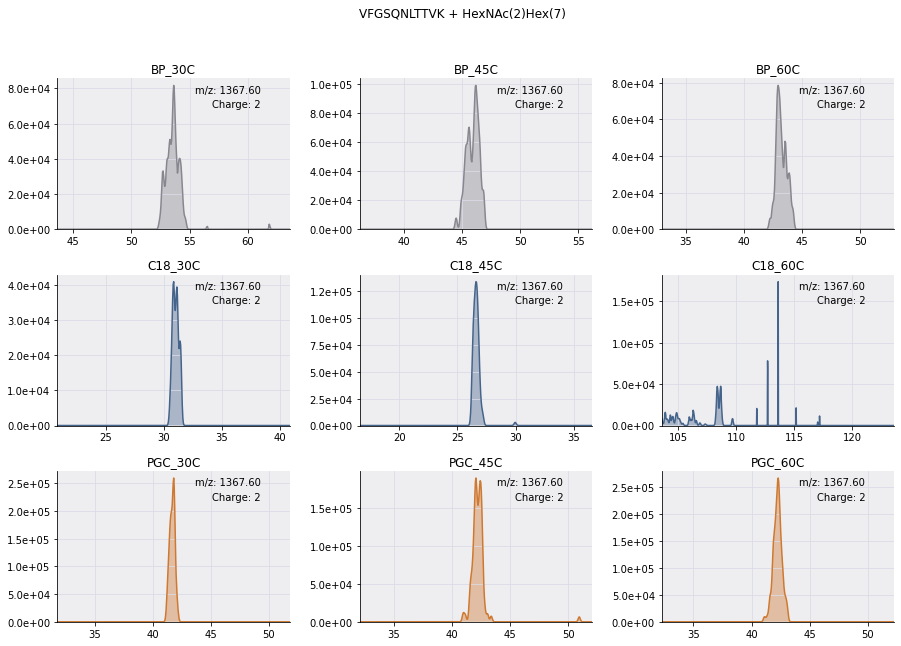

In [6]:
color_dict = {
    'BP':'#88868F',
    'C18':'#45648B',
    'PGC':'#CE7830'
}

# plot each peptide 
for peptide in d:
    data = d[peptide]['arrays']
    masses = d[peptide]['masses']
    charges = d[peptide]['charges']
    sources = d[peptide]['sources']
    glycan = d[peptide]['glycan'][0]
    sequence = d[peptide]['sequence'][0]

    title = sequence + ' + ' + glycan

    fig, axs = plt.subplots(3, 3, figsize=(15,10))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for i, ax in enumerate(axs.flat):
        arr = data[i]
        xs, ys = arr[0], arr[1]
        ys = gaussian_filter(ys, 2)
        idx = np.where(ys == np.max(ys))

        # ax = axs[i % 3][i // 3]
        # plot data
        ax = axs.flat[i]
        color = color_dict[sources[i].split('_')[0]]
        ax.plot(xs, ys, color=color)
        ax.fill_between(xs, 0, ys, facecolor=color, alpha=0.4)
        ax.set_xlim(xs[idx]-10, xs[idx]+10)
        ax.set_ylim(0, max(ys)*1.05)

        # add identifying text
        ax.set_title(sources[i])
        ax.text(xs[idx]+7.5, max(ys)*.95, f'm/z: {masses[i]:.2f}', ha='right')
        ax.text(xs[idx]+7.5, max(ys)*.85, f'Charge: {charges[i]}', ha='right')

        # format plots
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
        ax.set_facecolor('#EEEEF0')
        ax.grid(True, color='#dadbe6')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        fig.suptitle(title)
    plt.savefig('./MS1_Traces/BPC/'+title+'.png')
    plt.savefig('./MS1_Traces/BPC/'+title+'.svg')
    plt.close()